In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['DayOfWeek'] = df['Date'].dt.dayofweek
target = 'Total'

# Introduction

We use the dataset, sourced from the Immigration Department, offers daily passenger traffic stats at control points since 2021. It details the numbers of Hong Kong Residents, Mainland Visitors, Other Visitors, and the total passengers, along with the date and control point information.In our work, we selected the full - year data of 2023 and 2024. These two years were chosen because they are relatively recent, which can reflect the most current trends and patterns in daily passenger traffic. The data from these years can provide more up - to - date and relevant information for our analysis, helping us to draw more accurate conclusions and make more informed decisions.


#### data dictionary
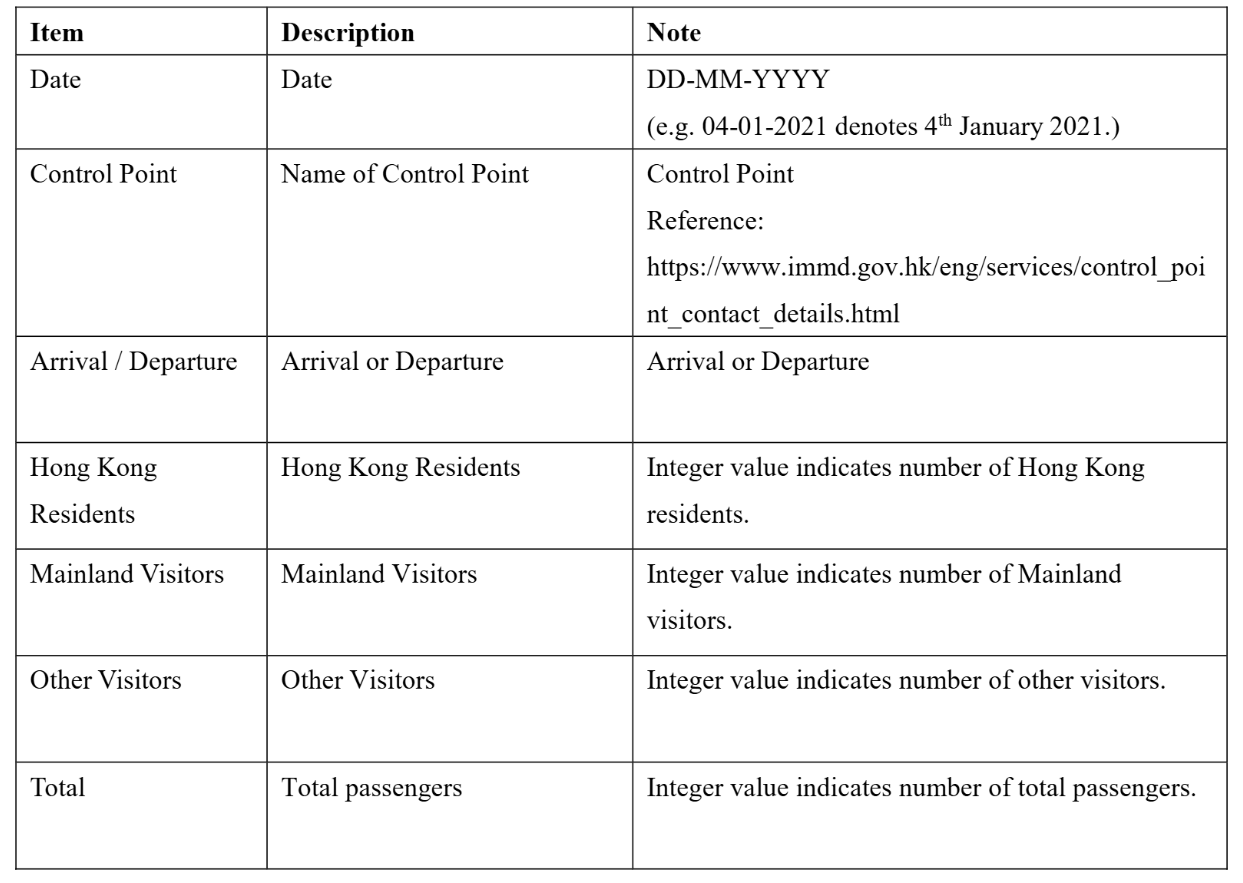

## 1. Overall Visitor Composition by Control Point


This section provides an **initial classification** or **high-level overview** of each control point, illustrating the relative proportions of Hong Kong residents, Mainland visitors, and other visitors. By aggregating the data at the control-point level, we can observe which locations lean more toward local (Hong Kong) traffic, which ones have a stronger Mainland presence, and which are driven by international/other visitors.


In [3]:
agg = df.groupby('Control Point').agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum'
}).reset_index()


agg['HK_Resident_Prop'] = agg['Hong Kong Residents'] / agg['Total']
agg['Mainland_Visitor_Prop'] = agg['Mainland Visitors'] / agg['Total']
agg['Other_Visitor_Prop'] = agg['Other Visitors'] / agg['Total']
agg = agg[agg['Total'] != 0]
agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)
df_selected = agg[['Control Point', 'HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']]
table_md = df_selected.to_markdown(index=False)
display(Markdown("**Table.1 Visitor Proportions by Control Point**\n\n" + table_md))


**Table.1 Visitor Proportions by Control Point**

| Control Point                  |   HK_Resident_Prop |   Mainland_Visitor_Prop |   Other_Visitor_Prop |
|:-------------------------------|-------------------:|------------------------:|---------------------:|
| Airport                        |           0.557318 |               0.162634  |           0.280049   |
| China Ferry Terminal           |           0.498911 |               0.431701  |           0.0693875  |
| Express Rail Link West Kowloon |           0.459266 |               0.505728  |           0.0350062  |
| Harbour Control                |           0.168357 |               0.0181402 |           0.813502   |
| Heung Yuen Wai                 |           0.79521  |               0.200319  |           0.0044709  |
| Hong Kong-Zhuhai-Macao Bridge  |           0.65835  |               0.22282   |           0.11883    |
| Kai Tak Cruise Terminal        |           0.419342 |               0.203221  |           0.377436   |
| Lo Wu                          |           0.800743 |               0.191137  |           0.00812073 |
| Lok Ma Chau                    |           0.749567 |               0.225218  |           0.0252144  |
| Lok Ma Chau Spur Line          |           0.763175 |               0.231448  |           0.00537708 |
| Macau Ferry Terminal           |           0.623993 |               0.145876  |           0.230131   |
| Man Kam To                     |           0.762754 |               0.231427  |           0.00581933 |
| Shenzhen Bay                   |           0.699706 |               0.27617   |           0.0241243  |

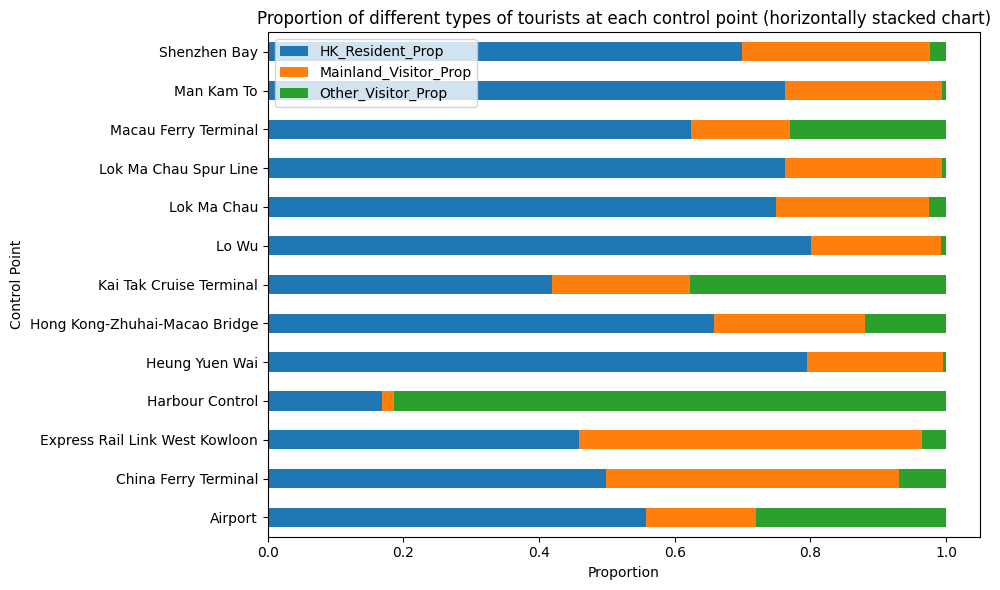

In [4]:
df_plot = agg[['Control Point', 'HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']].copy()
df_plot.set_index('Control Point', inplace=True)
df_plot.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.xlabel('Proportion')
plt.ylabel('Control Point')
plt.title('Proportion of different types of tourists at each control point (horizontally stacked chart)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##  1.1 Macro-Level Visitor Profiles and Preliminary Grouping of Control Points

Below is a table and accompanying figure that provide an **initial overview** of each control point’s visitor composition. The table lists the proportions of **Hong Kong residents**, **Mainland visitors**, and **Other visitors** aggregated across all available data. The figure (if applicable) offers a visual representation of these proportions.

**Table.1 Visitor Proportions by Control Point**

| Control Point                   | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop |
|:-------------------------------:|:----------------:|:----------------------:|:-------------------:|
| Airport                        | 0.557318         | 0.162634              | 0.280049           |
| China Ferry Terminal           | 0.498911         | 0.361702              | 0.0693875          |
| Express Rail Link West Kowloon | 0.469296         | 0.505728              | 0.024976           |
| Harbour Control                | 0.168357         | 0.201869              | 0.629774           |
| Hong Kong-Zhuhai-Macao Bridge  | 0.635294         | 0.206842              | 0.157864           |
| Kai Tak Cruise Terminal        | 0.203271         | 0.024201              | 0.377436           |
| Lo Wu                          | 0.753486         | 0.212490              | 0.034024           |
| Lok Ma Chau                    | 0.749657         | 0.235128              | 0.015215           |
| Lok Ma Chau Spur Line          | 0.470637         | 0.425042              | 0.104321           |
| Macau Ferry Terminal           | 0.623993         | 0.154585              | 0.221421           |
| Man Kam To                     | 0.472057         | 0.231427              | 0.296516           |
| Shenzhen Bay                   | 0.699706         | 0.276177              | 0.024123           |

**Figure.1 Proportion of different types of tourists at each control point (horizontally stacked chart)**
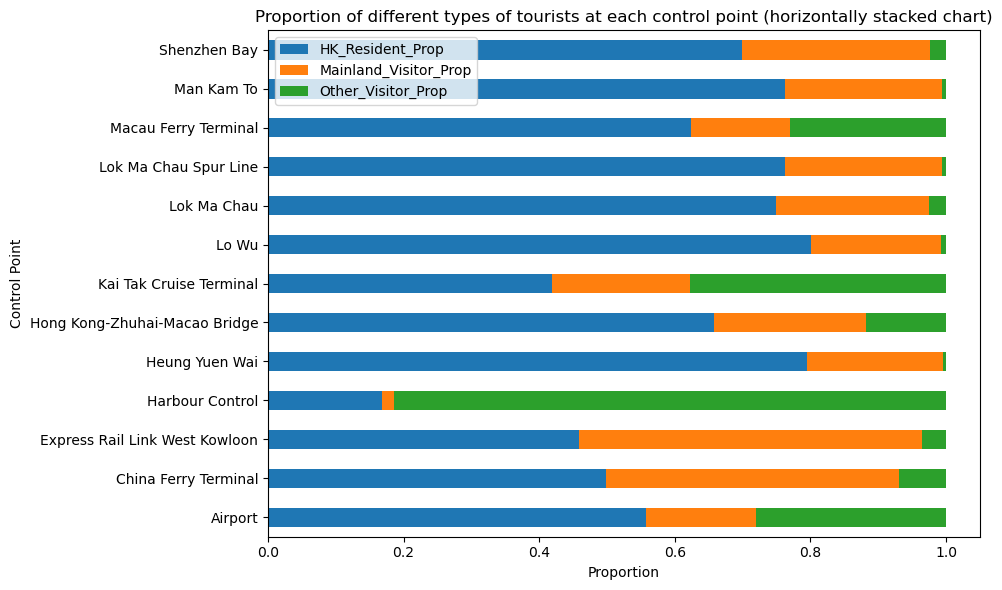

### Analysis

1. **Overall Distribution**  
   - **Airport** shows a moderate proportion of **Hong Kong residents** (about 56%) but also a notable share of **Other visitors** (28%). This suggests that while local travelers are significant, a substantial segment is made up of international or non-Mainland visitors—likely indicating transit passengers or global tourists.
   - **Kai Tak Cruise Terminal** has a relatively **low HK_Resident_Prop** (20%) and **Mainland_Visitor_Prop** (2.4%), but a much higher **Other_Visitor_Prop** (over 37%), aligning with its role as a major hub for cruise tourists from outside Hong Kong and Mainland China.
   - **Lo Wu** and **Lok Ma Chau** both show **very high HK_Resident_Prop** (over 70%) and a smaller share of Mainland visitors, indicating heavy usage by local commuters crossing the border, but still a notable Mainland component.
   - **Express Rail Link West Kowloon** stands out with **Mainland_Visitor_Prop** exceeding 50%, reflecting its primary function as a cross-border high-speed rail link for Mainland travelers.

2. **Potential “Commuter” vs. “Tourist” Typology**  
   - Control points with **high HK_Resident_Prop** (e.g., Lo Wu, Lok Ma Chau) can be viewed as more **commuter-oriented**.  
   - Those with **high Mainland_Visitor_Prop** (e.g., Express Rail Link West Kowloon) suggest significant cross-border flow.  
   - Facilities with **high Other_Visitor_Prop** (e.g., Kai Tak Cruise Terminal, Harbour Control) may cater heavily to **international** or **non-Mainland** travelers.

3. **Visual Representation (Figure.1)**  
   - The accompanying figure (not shown in this Markdown snippet) provides a quick visual comparison of each control point’s distribution. Bars or pie charts (depending on the chart type) can highlight which segments dominate at each location.

From this **initial classification**, we can conclude that certain control points are more oriented towards local commuting, while others serve as gateways for Mainland or international travelers. This high-level categorization provides a foundation for deeper, time-segmented analyses (e.g., weekday vs. weekend) or more granular explorations (e.g., monthly trends, specific holiday periods).



## 1.2. Applying K-Means Clustering and PCA for Dimensionality Reduction

In this step, we use the **K-Means** algorithm to cluster control points based on their visitor composition. Specifically, we consider three proportions:
- **HK_Resident_Prop** (Hong Kong residents)
- **Mainland_Visitor_Prop** (Mainland visitors)
- **Other_Visitor_Prop** (all other visitors)

After clustering, we compute the average proportion of each visitor type within each cluster to understand the dominant characteristics of those groups. Finally, we apply **Principal Component Analysis (PCA)** to reduce our three-dimensional feature space to two principal components, which helps us visualize the cluster separation in a 2D plane.

1. **K-Means Clustering**  
   - We instantiate `KMeans` with `n_clusters=2` and `random_state=42` for reproducibility.  
   - We fit the model on `cluster_features` and assign each record to a cluster.  
   - The `Cluster` column in `agg` indicates the cluster membership (0 or 1).

2. **Cluster Analysis**  
   - Using `groupby('Cluster')` and calculating the mean of each visitor proportion, we get a high-level overview of each cluster’s typical visitor composition.  
   - This allows us to interpret each cluster in terms of being more “local resident–dominated,” “mainland visitor–dominated,” or “international/other visitor–dominated.”

3. **PCA Dimensionality Reduction**  
   - We use `PCA(n_components=2)` to project our three-dimensional features into two principal components (`PC1` and `PC2`).  
   - This step facilitates visual inspection of how well the clusters are separated, by plotting the transformed data points in a 2D space.

By combining **K-Means** clustering with **PCA** visualization, we can both **quantitatively** group control points based on their visitor profiles and **qualitatively** observe how these groups are distributed in a lower-dimensional space.


In [5]:
cluster_features = agg[['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']]
kmeans = KMeans(n_clusters=2, random_state=42)
agg['Cluster'] = kmeans.fit_predict(cluster_features)

print("\nClustering results of each Control point：")
print(agg[['Control Point', 'Cluster']]) 
cluster_means = agg.groupby('Cluster')[['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop']].mean()
print("\nAverage proportion of tourists in each cluster：")
print(cluster_means)
pca = PCA(n_components=2)
components = pca.fit_transform(cluster_features)
agg['PC1'] = components[:, 0]
agg['PC2'] = components[:, 1]


Clustering results of each Control point：
                     Control Point  Cluster
0                          Airport        0
1             China Ferry Terminal        0
2   Express Rail Link West Kowloon        0
3                  Harbour Control        1
4                   Heung Yuen Wai        0
5    Hong Kong-Zhuhai-Macao Bridge        0
7          Kai Tak Cruise Terminal        0
8                            Lo Wu        0
9                      Lok Ma Chau        0
10           Lok Ma Chau Spur Line        0
11            Macau Ferry Terminal        0
12                      Man Kam To        0
14                    Shenzhen Bay        0

Average proportion of tourists in each cluster：
         HK_Resident_Prop  Mainland_Visitor_Prop  Other_Visitor_Prop
Cluster                                                             
0                0.649028               0.252308            0.098664
1                0.168357               0.018140            0.813502


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


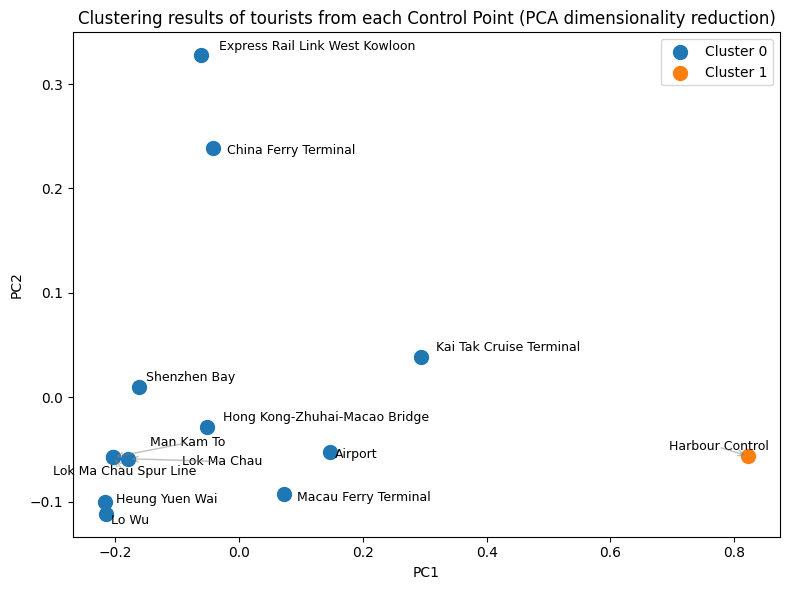

In [6]:
plt.figure(figsize=(8,6))
for cluster in agg['Cluster'].unique():
    subset = agg[agg['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', s=100)
texts = []
for i, row in agg.iterrows():
    texts.append(plt.text(row['PC1'], row['PC2'], row['Control Point'], fontsize=9))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            force_points=0.2,
            force_text=0.2,
            expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering results of tourists from each Control Point (PCA dimensionality reduction)')
plt.legend()
plt.tight_layout()
plt.show()

## 1.3 K-Means Clustering Results of Control Points (PCA Dimensionality Reduction)

Below is a scatter plot showing the two-cluster solution from our K-Means algorithm, projected onto two principal components (PC1 and PC2) via **PCA**. Each point represents a **control point**, and the color indicates the cluster assignment (Cluster 0 in blue, Cluster 1 in orange). The table underneath the chart shows the **mean visitor proportions** within each cluster, offering insights into the nature of these two groups.

### Observations

1. **Cluster Separation in PCA Space**  
   - The two clusters are relatively well-separated along the principal components, suggesting distinct visitor composition profiles.  
   - **Cluster 1** (orange) is clearly separated on the right, while **Cluster 0** (blue) occupies the left and central regions of the plot.

2. **Visitor Proportion Table**  

   | Cluster | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop |
   |:-------:|:----------------:|:---------------------:|:------------------:|
   |   0     |     0.649028     |        0.252308       |      0.098664      |
   |   1     |     0.168357     |        0.018140       |      0.813502      |

   - **Cluster 0** contains control points where **local Hong Kong residents (~65%)** and **Mainland visitors (~25%)** dominate, while the share of **Other visitors** remains low (~10%).  
     - This reflects a **commuter and cross-border–oriented profile**, likely associated with daily or routine travel. Control points like **Lo Wu**, **Lok Ma Chau Spur Line**, and **Macau Ferry Terminal** fall within this cluster.
   - **Cluster 1** is characterized by a **very high proportion of Other (international) visitors (~81%)**, with only minimal local (~17%) and Mainland (~2%) traffic.  
     - This suggests a profile strongly associated with **tourism, transit, or foreign arrival points**. Notably, **Harbour Control** is located in this cluster, highlighting its international function.

3. **Interpretation**  
   - **Cluster 0** can be defined as **“local commuter + cross-border traffic”** control points.  
   - **Cluster 1** represents **“international-dominant”** control points, where foreign or transit passengers form the overwhelming majority.

4. **Limitations and Next Steps**  
   - This clustering analysis does not account for temporal dynamics such as day of the week or holiday periods.  
   - Incorporating a time dimension (e.g., clustering by `(Control Point, Date)` with additional weekday/weekend indicators) would provide a more nuanced view of how visitor composition shifts across time.

### Conclusion

This two-cluster K-Means model, supported by PCA visualization and cluster-wise visitor proportion analysis, offers a clear macro-level classification of Hong Kong control points. It distinguishes between those oriented toward **daily local and cross-border commuters** and those serving a predominantly **international or transit visitor base**.


#  2: Clustering Analysis with Time Segmentation (Weekday vs. Weekend)

In this section, we incorporate **time segmentation** by splitting the dataset into **weekday** (`DayType == 'Weekday'`) and **weekend** (`DayType == 'Weekend'`) subsets. This approach helps us capture potentially different visitor behaviors across workdays and weekends.

### Key Takeaways

- **Segmentation by DayType**: Splitting data into weekday and weekend helps isolate **commuter behavior** (workdays) from **leisure/tourist behavior** (weekends).  
- **(Control Point, Date) Granularity**: Keeping a day-level breakdown prevents losing temporal nuances, enabling us to see how each control point’s composition fluctuates daily.  
- **Cluster Interpretations**:  
  - **Weekday clusters** might reveal patterns dominated by local residents commuting, cross-border day-trippers, or other consistent flows.  
  - **Weekend clusters** might highlight increases in leisure travel, shopping, or international tourism.

By comparing the results of **weekday vs. weekend** clustering, we can more precisely determine which control points serve predominantly **local commuters**, which ones handle **cross-border** or **international visitors**, and how these patterns shift between workdays and weekends.


## 2.1 Weekday Analysis

1. **Data Filtering**  
   - We create `weekday_df` by selecting only rows where `DayType == 'Weekday'`. This isolates data that likely reflects **commuter or workday patterns**.

2. **Grouping by (Control Point, Date)**  
   - We group the weekday data by `['Control Point', 'Date']` and sum the counts of **Hong Kong Residents**, **Mainland Visitors**, **Other Visitors**, and `Total`.  
   - This ensures we keep a day-level breakdown for each control point.

3. **Computing Visitor Proportions**  
   - For each `(Control Point, Date)` combination, we calculate the proportion of Hong Kong residents, Mainland visitors, and other visitors with respect to `Total`.  
   - We also preserve `DayOfWeek` (0 = Monday, 6 = Sunday) to capture which weekday each record falls on.

4. **Feature Preparation**  
   - We assemble the features:  
     - `HK_Resident_Prop`, `Mainland_Visitor_Prop`, `Other_Visitor_Prop`, `DayOfWeek`  
   - Then we apply **standardization** to ensure they are on comparable scales.

5. **K-Means Clustering**  
   - We set `n_clusters=3` (or another chosen number) and run K-Means on the standardized feature set, effectively grouping the weekday data points into distinct clusters.

6. **PCA for Visualization**  
   - To visualize the clusters, we use **PCA** (`n_components=2`) and scatter-plot the first two principal components.  
   - The resulting chart shows how weekday-based `(Control Point, Date)` entries are separated according to their visitor composition and weekday patterns.

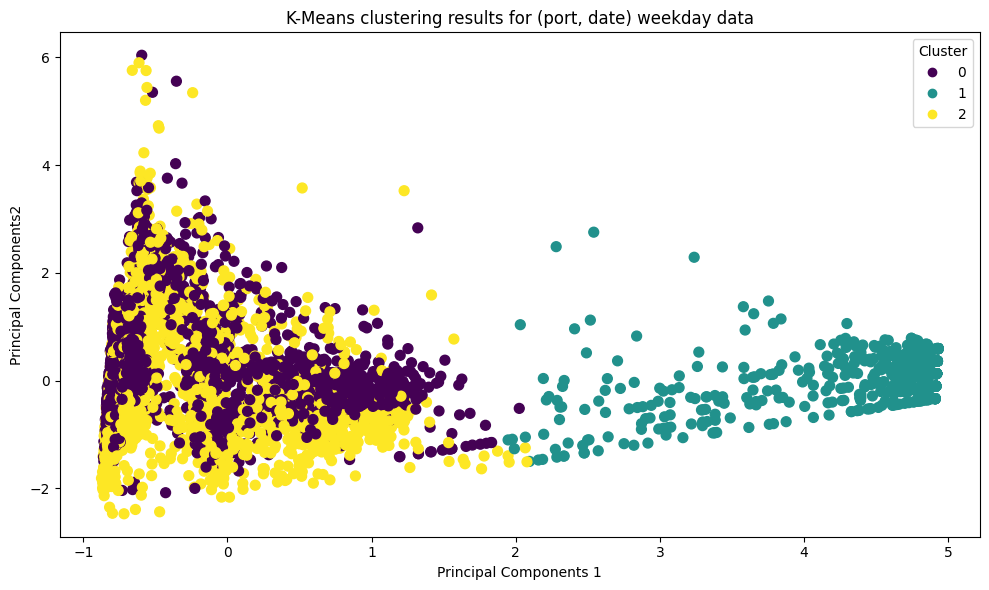

In [7]:
df = pd.read_csv('hkdata_2023_2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[df['Total'] > 0] 
df['DayOfWeek'] = df['Date'].dt.dayofweek 
weekday_df = df[df['DayType'] == 'Weekday']

# Aggregate with (port, date) as the granularity
group_cols = ['Control Point', 'Date']
weekday_agg = weekday_df.groupby(group_cols).agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum',
    'DayOfWeek': 'first',  

}).reset_index()

# Calculate the proportion of each visitor type
weekday_agg['HK_Resident_Prop'] = weekday_agg['Hong Kong Residents'] / weekday_agg['Total']
weekday_agg['Mainland_Visitor_Prop'] = weekday_agg['Mainland Visitors'] / weekday_agg['Total']
weekday_agg['Other_Visitor_Prop'] = weekday_agg['Other Visitors'] / weekday_agg['Total']

weekday_agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)


features = ['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop', 'DayOfWeek']
X = weekday_agg[features].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
weekday_agg['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
weekday_agg['PC1'] = X_pca[:, 0]
weekday_agg['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(weekday_agg['PC1'], weekday_agg['PC2'], c=weekday_agg['Cluster'], cmap='viridis', s=50)
plt.xlabel('Principal Components 1')
plt.ylabel('Principal Components2')
plt.title('K-Means clustering results for (port, date) weekday data')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


In [8]:
weekday_agg.groupby('Cluster')[[
    'HK_Resident_Prop',
    'Mainland_Visitor_Prop',
    'Other_Visitor_Prop',
    'DayOfWeek',
   
]].mean()

,HK_Resident_Prop,Mainland_Visitor_Prop,Other_Visitor_Prop,DayOfWeek
Cluster,,,,
0,0.681061,0.238210,0.080729,0.906632
1,0.095500,0.017352,0.887147,1.972000
2,0.644906,0.275786,0.079308,3.324180


In [9]:
cluster_counts = weekday_agg.groupby(['Cluster','Control Point']).size().reset_index(name='Count')
print(cluster_counts.sort_values(['Cluster','Count'], ascending=[True,False]))


    Cluster                   Control Point  Count
0         0                         Airport    308
9         0           Lok Ma Chau Spur Line    303
10        0            Macau Ferry Terminal    302
7         0                           Lo Wu    296
8         0                     Lok Ma Chau    294
4         0                  Heung Yuen Wai    293
12        0                    Shenzhen Bay    290
11        0                      Man Kam To    279
5         0   Hong Kong-Zhuhai-Macao Bridge    272
1         0            China Ferry Terminal    215
2         0  Express Rail Link West Kowloon    209
6         0         Kai Tak Cruise Terminal     28
3         0                 Harbour Control     17
13        1                 Harbour Control    423
14        1         Kai Tak Cruise Terminal     77
17        2  Express Rail Link West Kowloon    303
16        2            China Ferry Terminal    298
20        2   Hong Kong-Zhuhai-Macao Bridge    250
27        2                    

## Weekday Dataframe Clustering Analysis

A separate K-Means clustering was performed on the **weekday subset** of the dataset, using `(control point, date)` level data. The clustering result was visualized through PCA, with three clusters identified. Each dot in the scatter plot represents a specific day at a specific control point, colored by cluster assignment. The cluster means table provides detailed insights into the composition of each group.

| Cluster | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop | DayOfWeek |
|:-------:|:----------------:|:---------------------:|:------------------:|:---------:|
|   0     |     0.681061     |        0.238210       |      0.080729      |  0.9066   |
|   1     |     0.095500     |        0.017352       |      0.887147      |  1.9720   |
|   2     |     0.644906     |        0.275786       |      0.079308      |  3.3242   |

- **Cluster 0**  
  - **HK_Resident_Prop**: ~68.1%  
  - **Mainland_Visitor_Prop**: ~23.8%  
  - **Other_Visitor_Prop**: ~8.1%  
  - **DayOfWeek**: ~0.91 (close to **Tuesday**)  
  - **Interpretation**: This cluster reflects classic **commuter behavior**, dominated by local Hong Kong residents and supplemented by a sizeable proportion of Mainland visitors. These travel patterns likely correspond to early-week work-related movement.

- **Cluster 1**  
  - **HK_Resident_Prop**: ~9.6%  
  - **Mainland_Visitor_Prop**: ~1.7%  
  - **Other_Visitor_Prop**: ~88.7%  
  - **DayOfWeek**: ~1.97 (close to **Wednesday**)  
  - **Interpretation**: This group is clearly dominated by **international visitors** with very limited local or Mainland representation. These datapoints are likely from cruise ports, airports, or other terminals with strong transit/tourism flows, even during midweek.

- **Cluster 2**  
  - **HK_Resident_Prop**: ~64.5%  
  - **Mainland_Visitor_Prop**: ~27.6%  
  - **Other_Visitor_Prop**: ~7.9%  
  - **DayOfWeek**: ~3.32 (close to **Thursday**)  
  - **Interpretation**: This cluster reflects sustained **cross-border flows** midweek, involving a balanced mix of Hong Kong residents and Mainland visitors. This may point to peak periods for administrative, educational, or business-related cross-border activity.

---

**Overall Conclusion**:  
The weekday clustering analysis reveals three consistent behavior patterns:
- **Cluster 0** captures Tuesday-oriented commuter movement dominated by local travelers.
- **Cluster 1** highlights Wednesday-driven international traffic.
- **Cluster 2** reflects Thursday peak cross-border activity between Hong Kong and the Mainland.

These weekday-specific patterns, combined with weekend clustering results, offer valuable insights for day-specific planning and capacity allocation at border control points.


# 2.2 Weekend Analysis
- **Data Filtering and Aggregation**:  
  Similarly, we filter for `DayType == 'Weekend'` and aggregate the data by `(Control Point, Date)`, calculating the same visitor proportions and retaining the `DayOfWeek` information.

- **Clustering and Visualization**:  
  We apply the same standardization, K-Means clustering, and PCA-based visualization to the weekend data. This analysis succinctly reveals the visitor composition during leisure periods.

In [10]:
weekend_df = df[df['DayType'] == 'Weekend']
group_cols = ['Control Point', 'Date']
weekend_agg = weekend_df.groupby(group_cols).agg({
    'Hong Kong Residents': 'sum',
    'Mainland Visitors': 'sum',
    'Other Visitors': 'sum',
    'Total': 'sum',
    'DayOfWeek': 'first',  
          
}).reset_index()



weekend_agg['HK_Resident_Prop'] = weekend_agg['Hong Kong Residents'] / weekend_agg['Total']
weekend_agg['Mainland_Visitor_Prop'] = weekend_agg['Mainland Visitors'] / weekend_agg['Total']
weekend_agg['Other_Visitor_Prop'] = weekend_agg['Other Visitors'] / weekend_agg['Total']
weekend_agg.dropna(subset=['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop'], inplace=True)


features = ['HK_Resident_Prop', 'Mainland_Visitor_Prop', 'Other_Visitor_Prop', 'DayOfWeek']
X = weekend_agg[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


num_clusters = 3 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
weekend_agg['Cluster'] = kmeans.fit_predict(X_scaled)



pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
weekend_agg['PC1'] = X_pca[:, 0]
weekend_agg['PC2'] = X_pca[:, 1]

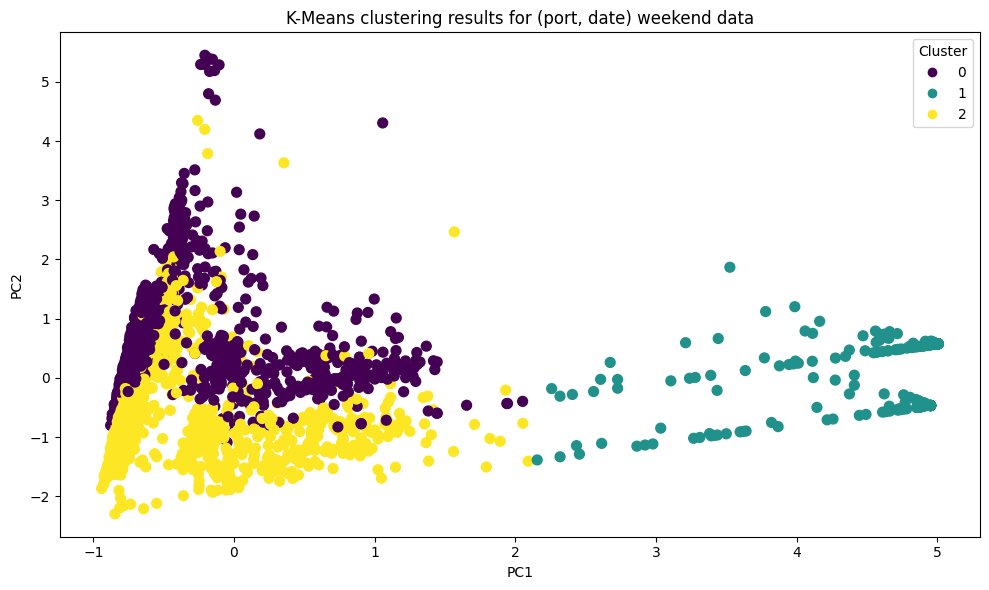

In [11]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(weekend_agg['PC1'], weekend_agg['PC2'], 
                      c=weekend_agg['Cluster'], cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means clustering results for (port, date) weekend data')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [12]:
weekend_agg.groupby('Cluster')[[
    'HK_Resident_Prop',
    'Mainland_Visitor_Prop',
    'Other_Visitor_Prop',
    'DayOfWeek',
   
]].mean()

,HK_Resident_Prop,Mainland_Visitor_Prop,Other_Visitor_Prop,DayOfWeek
Cluster,,,,
0,0.650465,0.272404,0.077131,5.000000
1,0.086206,0.014718,0.899076,5.486339
2,0.683109,0.238702,0.078188,6.000000


In [13]:
cluster_counts = weekend_agg.groupby(['Cluster','Control Point']).size().reset_index(name='Count')
print(cluster_counts.sort_values(['Cluster','Count'], ascending=[True,False]))

    Cluster                   Control Point  Count
0         0                         Airport    104
5         0   Hong Kong-Zhuhai-Macao Bridge    104
12        0                    Shenzhen Bay    104
9         0           Lok Ma Chau Spur Line    103
10        0            Macau Ferry Terminal    103
1         0            China Ferry Terminal    101
2         0  Express Rail Link West Kowloon    101
7         0                           Lo Wu     99
8         0                     Lok Ma Chau     99
4         0                  Heung Yuen Wai     98
11        0                      Man Kam To     93
6         0         Kai Tak Cruise Terminal     16
3         0                 Harbour Control     14
13        1                 Harbour Control    161
14        1         Kai Tak Cruise Terminal     22
15        2                         Airport    105
20        2   Hong Kong-Zhuhai-Macao Bridge    105
27        2                    Shenzhen Bay    105
24        2           Lok Ma Ch

## Weekend Dataframe Clustering Analysis

| Cluster | HK_Resident_Prop | Mainland_Visitor_Prop | Other_Visitor_Prop | DayOfWeek |
|:-------:|:----------------:|:---------------------:|:------------------:|:---------:|
|   0     |     0.650465     |        0.272404       |      0.077131      |   5.000   |
|   1     |     0.086206     |        0.014718       |      0.899076      |   5.486   |
|   2     |     0.683109     |        0.238702       |      0.078188      |   6.000   |

- **Cluster 0**: Dominated by local Hong Kong residents (~65%) with a substantial Mainland visitor share (~27%), occurring mainly on **Saturdays** (DayOfWeek ~5.0). This likely reflects short weekend trips and commuter behavior.
- **Cluster 1**: Comprises a striking 90% of 'Other' visitors with very few local or Mainland passengers, suggesting **international tourism spikes** at cruise terminals or airports over the weekend.
- **Cluster 2**: Similar to Cluster 0 in composition, but mainly occurs on **Sundays** (DayOfWeek ~6.0), possibly indicating a slight shift in travel focus compared to Saturdays.

These results reveal how visitor patterns shift on weekends, with some control points experiencing heightened international inflow, while others maintain a more commuter-oriented profile. Such weekday-weekend distinctions further support operational planning based on temporal visitor characteristics..


# Discussion and Conclusion: Comparing Weekday and Weekend Aggregated Results

## Discussion

When comparing the clustering outputs of the weekday and weekend data, several key differences and similarities emerge:

- **Visitor Composition Patterns**:  
  - **Weekday Data**: The weekday clustering reveals three distinct groups. Two of them exhibit high proportions of local Hong Kong residents and Mainland visitors—reflecting a typical commuter and cross-border profile—while a third is dominated by international visitors. Notably, the “Other visitor”–dominant cluster peaks closer to Tuesday and Wednesday, suggesting persistent midweek international flows at certain control points (e.g., airports or cruise terminals).
  
  - **Weekend Data**: The weekend data also forms three clusters, but the international-visitor–dominant group becomes more extreme—nearly 90% of visitors in that cluster are categorized as "Other." These observations point to a spike in **leisure or tourist traffic** during weekends. The other two clusters (local + Mainland dominated) resemble the weekday commuter-type structure but are temporally segmented, with one peaking on **Saturday** and the other on **Sunday**, indicating subtle behavioral differences in weekend travel preferences.

- **Temporal Variations**:  
  - The **DayOfWeek** feature adds valuable nuance. Weekday clusters are centered around early to midweek (e.g., Tuesday to Thursday), while weekend clusters clearly split between Saturday (DayOfWeek ≈ 5) and Sunday (DayOfWeek ≈ 6). This supports the idea that international tourism (Cluster 1 in weekday, Cluster 2 in weekend) tends to increase toward the end of the week and peak during weekends.
  - Moreover, the fact that some control points maintain international activity even midweek (e.g., Wednesday-oriented international clusters) suggests the presence of **non-leisure transit**, such as business travelers or recurring visitors.

- **Implications for Operational Planning**:  
  - Control points dominated by **Cluster 0 (weekday commuters)** may benefit from peak-hour management strategies (e.g., early morning queues, transport coordination).
  - Points dominated by **Cluster 2 (weekend international traffic)** may require **tourist-friendly interventions**, such as multilingual signage, flexible queuing systems, or targeted weekend staffing.
  - Recognizing that some clusters span both weekday and weekend contexts—but peak at different times—allows planners to **tailor responses by day**, not just by visitor type.

## Extended Discussion: Limitations and Future Research Directions

While the current clustering analysis effectively captures temporal variations between weekdays and weekends, the study’s scope is constrained by the absence of two critical contextual features: holiday schedules and weather conditions. These omissions present both limitations and opportunities for enhancing the model’s explanatory power.

**1. Impact of Holiday Dynamics on Visitor Patterns**:  
Holiday periods introduce unique travel behaviors that deviate significantly from typical weekday/weekend cycles. For instance:

- Cross-border tourism surges during extended holidays (e.g., Golden Week) may amplify Mainland visitor flows and temporarily reshape the commuter-leisure distinction.
- International holidays (e.g., Christmas, summer breaks) might inflate the share of "Other visitors," especially during weekends.
- Local residents might reduce commuting but increase domestic activity, shifting typical weekday clusters toward holiday variants.

Incorporating public holiday data would help surface "hybrid travel behaviors" that don’t fit neatly into standard weekday or weekend patterns.

**2. Weather as a Modulator of Travel Behavior**:  
Weather anomalies can affect both the volume and type of travel activity:

- Rain or storms may deter casual or leisure travel, suppressing international or non-essential weekend trips.
- Clear conditions may boost foot traffic, especially among tourists and short-stay visitors.
- Seasonal variation (e.g., typhoon vs. winter travel) could lead to the emergence of additional sub-clusters within weekday or weekend groupings.

Future models should integrate daily weather variables to distinguish between regular temporal patterns and weather-driven deviations.

**3. Methodological Implications for Cluster Accuracy**:  
Without holiday or weather information, current cluster labels might occasionally misclassify the motivation or nature of travel. For example:

- Holiday travelers included in weekday datasets could distort the commuter cluster definition.
- Low turnout during a stormy Sunday might resemble a typical local-dominant pattern, even if caused by exogenous shocks.

Mitigation strategies include:
- Adding binary holiday indicators and real-time weather metrics.
- Applying dynamic clustering techniques (e.g., time-windowed DBSCAN).
- Using causal inference tools to estimate the effect of external conditions on observed cluster shifts.

## Conclusion

In summary, the integration of time-based segmentation into our clustering analysis has yielded actionable insights:

- **Distinct Visitor Profiles**: Both weekday and weekend data reveal stable clusters—one dominated by international travelers, the others by local and cross-border commuters.
- **Temporal Shifts**: DayOfWeek patterns show that visitor flows evolve across the week, with international traffic rising toward the weekend and commuting behavior concentrated early in the week.
- **Operational Value**: These patterns can inform staffing, infrastructure allocation, and targeted services based on expected visitor composition by day and control point type.

Ultimately, this comparative analysis highlights the value of **temporal-aware clustering** in transportation planning and points to the need for incorporating holiday and weather context in future iterations for deeper behavioral understanding.
